In [1]:
import tensorflow as tf

In [117]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, TimeDistributed, Reshape, Activation, Dot, Bidirectional, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
from IPython.core.display import display, HTML
%matplotlib inline

In [4]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

# Loading Data

In [6]:
df = pd.read_csv("emotion.data")
df.head(10)

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love
5,18231,i find myself frustrated with christians becau...,love
6,10714,i am one of those people who feels like going ...,joy
7,35177,i feel especially pleased about this as this h...,joy
8,122177,i was struggling with these awful feelings and...,joy
9,26723,i feel so enraged but helpless at the same time,anger


In [36]:
df[df['emotions'].isnull()].values

array([[8438,
        'i cant help feeling that any gleefully hateful attitude is wrong whether it feels justifie',
        nan]], dtype=object)

In [37]:
df.loc[df['emotions'].isnull(),'emotions'] = 'anger'

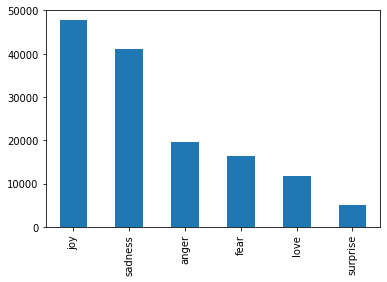

In [38]:
df.emotions.value_counts().plot.bar()

In [39]:
text_tokens = [text.split(" ") for text in df["text"].values.tolist()]
text = df["text"].values.tolist()
labels = df["emotions"].values.tolist()

In [40]:
print(text_tokens[0])

['i', 'feel', 'awful', 'about', 'it', 'too', 'because', 'it', 's', 'my', 'job', 'to', 'get', 'him', 'in', 'a', 'position', 'to', 'succeed', 'and', 'it', 'just', 'didn', 't', 'happen', 'here']


In [41]:
print(df['text'][0])

i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here


In [42]:
print(labels[0])

sadness


#### Tokenizer

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
word2id = tokenizer.word_index
id2word = dict([(value, key) for (key, value) in word2id.items()])

In [44]:
print(word2id)

{'i': 1, 'feel': 2, 'and': 3, 'to': 4, 'the': 5, 'a': 6, 'feeling': 7, 'that': 8, 'of': 9, 'my': 10, 'in': 11, 'it': 12, 'like': 13, 'so': 14, 'for': 15, 'im': 16, 'have': 17, 'me': 18, 'but': 19, 'was': 20, 'is': 21, 'am': 22, 'this': 23, 'with': 24, 'not': 25, 'about': 26, 'be': 27, 'as': 28, 'on': 29, 'you': 30, 'just': 31, 'when': 32, 'at': 33, 'or': 34, 'all': 35, 'because': 36, 'more': 37, 'do': 38, 'can': 39, 'really': 40, 't': 41, 'up': 42, 'know': 43, 'very': 44, 'are': 45, 'by': 46, 'been': 47, 'out': 48, 'what': 49, 'myself': 50, 'time': 51, 'if': 52, 'how': 53, 'get': 54, 'had': 55, 'will': 56, 'little': 57, 'now': 58, 'from': 59, 'people': 60, 'being': 61, 'they': 62, 'would': 63, 'want': 64, 'her': 65, 'he': 66, 'them': 67, 'still': 68, 'one': 69, 'think': 70, 'some': 71, 'ive': 72, 'even': 73, 'who': 74, 'much': 75, 'an': 76, 'we': 77, 'life': 78, 'him': 79, 'there': 80, 'its': 81, 'something': 82, 's': 83, 'things': 84, 'way': 85, 'm': 86, 'make': 87, 'bit': 88, 'dont':

In [45]:
vocab_size = len(word2id) + 1
vocab_size

45176

#### Generating Data

In [46]:
# transforming text into tokens
X = [[word2id[word] for word in sent] for sent in text_tokens]
print(X[0])

[1, 2, 462, 26, 12, 95, 36, 12, 83, 10, 322, 4, 54, 79, 11, 6, 1229, 4, 3002, 3, 12, 31, 259, 41, 520, 134]


In [47]:
lens = []
for i in X:
  lens.append(len(i))
print(np.mean(lens),np.min(lens),np.max(lens))

19.208372656459087 1 101


In [48]:
embedding_dim = 100
max_len = 100

In [49]:
pad = 'post'
X_pad = pad_sequences(X, maxlen=max_len, padding=pad, truncating=pad)

In [50]:
# testing
print(X_pad[0])

[   1    2  462   26   12   95   36   12   83   10  322    4   54   79
   11    6 1229    4 3002    3   12   31  259   41  520  134    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [88]:
lens = []
for i in X_pad:
  lens.append(len(i))
print(np.mean(lens),np.min(lens),np.max(lens))

100.0 100 100


In [51]:
# labels
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'anger', 1: 'love', 2: 'fear', 3: 'joy', 4: 'sadness', 5: 'surprise'}

In [52]:
y = [label2id[label] for label in labels]

In [53]:
y = to_categorical(y, num_classes=len(label2id), dtype='float32')

In [89]:
lens = []
for i in y:
  lens.append(len(i))
print(np.mean(lens),np.min(lens),np.max(lens))

6.0 6 6


In [54]:
# testing
y[0]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [55]:
print("X (shape): {}".format(X_pad.shape))
print("y (shape): {}".format(y.shape))

X (shape): (141986, 100)
y (shape): (141986, 6)


#### Creating Model My Attention

In [56]:
embedding_dim = 100
max_len = 100

In [69]:
np.array(X_pad).shape, y.shape

((141986, 100), (141986, 6))

In [131]:
model = Sequential()
model.add(Input(shape=(max_len,), dtype='int32'))
model.add(Embedding(vocab_size,embedding_dim,input_length=max_len))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True)))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(1)))
model.add(Attention(return_sequences=True))
model.add(Flatten())
model.add(Dense(embedding_dim,activation='relu'))
model.add(Dense(len(label2id), activation='softmax', name='final'))

In [132]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 100)          4517600   
_________________________________________________________________
dropout_38 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 100, 200)          160800    
_________________________________________________________________
dropout_39 (Dropout)         (None, 100, 200)          0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 100, 1)            201       
_________________________________________________________________
attention_16 (Attention)     (None, 100, 1)            101       
_________________________________________________________________
flatten_3 (Flatten)          (None, 100)             

In [133]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

In [135]:
model.fit(X_pad, y, epochs=10, batch_size=128, validation_split=0.2, shuffle=True, verbose=2)

Epoch 1/10
888/888 - 47s - loss: 0.1448 - accuracy: 0.9341 - val_loss: 0.1537 - val_accuracy: 0.9271
Epoch 2/10
888/888 - 47s - loss: 0.1200 - accuracy: 0.9425 - val_loss: 0.1530 - val_accuracy: 0.9256
Epoch 3/10
888/888 - 47s - loss: 0.1049 - accuracy: 0.9485 - val_loss: 0.1596 - val_accuracy: 0.9263
Epoch 4/10
888/888 - 47s - loss: 0.0988 - accuracy: 0.9513 - val_loss: 0.1700 - val_accuracy: 0.9274
Epoch 5/10
888/888 - 47s - loss: 0.0925 - accuracy: 0.9546 - val_loss: 0.1790 - val_accuracy: 0.9238
Epoch 6/10
888/888 - 47s - loss: 0.0851 - accuracy: 0.9591 - val_loss: 0.1870 - val_accuracy: 0.9260
Epoch 7/10
888/888 - 47s - loss: 0.0820 - accuracy: 0.9603 - val_loss: 0.1777 - val_accuracy: 0.9240
Epoch 8/10
888/888 - 47s - loss: 0.0740 - accuracy: 0.9640 - val_loss: 0.1739 - val_accuracy: 0.9250
Epoch 9/10
888/888 - 47s - loss: 0.0689 - accuracy: 0.9654 - val_loss: 0.1942 - val_accuracy: 0.9226
Epoch 10/10
888/888 - 47s - loss: 0.0653 - accuracy: 0.9677 - val_loss: 0.1986 - val_accura

#### Another Model

In [140]:
seq_input = Input(shape=(max_len,), dtype='int32')
embedded = Embedding(vocab_size,
                     embedding_dim,
                     input_length=max_len)(seq_input)
embedded = Dropout(0.2)(embedded)
lstm = Bidirectional(LSTM(embedding_dim, return_sequences=True))(embedded)
lstm = Dropout(0.2)(lstm)
# Attention Mechanism
att_vector = TimeDistributed(Dense(1))(lstm)
att_vector = Reshape((max_len,))(att_vector)
att_vector = Activation('softmax', name='attention_vec')(att_vector)
att_output = Dot(axes=1)([lstm, att_vector])
# Final Layers
fc = Dense(embedding_dim, activation='relu')(att_output)
output = Dense(len(label2id), activation='softmax')(fc)

In [141]:
model = Model(inputs=[seq_input], outputs=output)

In [142]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 100, 100)     4517600     input_24[0][0]                   
__________________________________________________________________________________________________
dropout_42 (Dropout)            (None, 100, 100)     0           embedding_23[0][0]               
__________________________________________________________________________________________________
bidirectional_22 (Bidirectional (None, 100, 200)     160800      dropout_42[0][0]                 
____________________________________________________________________________________________

In [143]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

In [144]:
%%time
model.fit(X_pad, y, epochs=10, batch_size=128, validation_split=0.2, shuffle=True, verbose=2)

Epoch 1/10
888/888 - 53s - loss: 0.6651 - accuracy: 0.7336 - val_loss: 0.1917 - val_accuracy: 0.9172
Epoch 2/10
888/888 - 48s - loss: 0.1369 - accuracy: 0.9348 - val_loss: 0.1197 - val_accuracy: 0.9317
Epoch 3/10
888/888 - 48s - loss: 0.0985 - accuracy: 0.9476 - val_loss: 0.1094 - val_accuracy: 0.9338
Epoch 4/10
888/888 - 48s - loss: 0.0866 - accuracy: 0.9524 - val_loss: 0.1133 - val_accuracy: 0.9321
Epoch 5/10
888/888 - 48s - loss: 0.0784 - accuracy: 0.9581 - val_loss: 0.1286 - val_accuracy: 0.9310
Epoch 6/10
888/888 - 48s - loss: 0.0743 - accuracy: 0.9608 - val_loss: 0.1468 - val_accuracy: 0.9293
Epoch 7/10
888/888 - 48s - loss: 0.0681 - accuracy: 0.9641 - val_loss: 0.1407 - val_accuracy: 0.9292
Epoch 8/10
888/888 - 48s - loss: 0.0635 - accuracy: 0.9658 - val_loss: 0.1718 - val_accuracy: 0.9278
Epoch 9/10
888/888 - 48s - loss: 0.0591 - accuracy: 0.9672 - val_loss: 0.1779 - val_accuracy: 0.9271
Epoch 10/10
888/888 - 48s - loss: 0.0556 - accuracy: 0.9699 - val_loss: 0.1896 - val_accura

Loading Attention Layer

In [145]:
model_att = Model(inputs=model.input,
                  outputs=[model.output, model.get_layer('attention_vec').output])

Testing sample Text

In [147]:
sample_text = random.choice(df["text"].values.tolist())
print(sample_text)

i was feeling rather melancholy and couldnt think of anything that wouldnt annoy me


In [148]:
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]
encoded_samples = pad_sequences(encoded_samples, maxlen=max_len)
label_probs, attentions = model_att.predict(encoded_samples)

probability each layer

In [149]:
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}
print(label_probs)

{'anger': 1.717203e-08, 'love': 1.16062e-11, 'fear': 2.4017655e-10, 'joy': 1.4130993e-07, 'sadness': 0.9999999, 'surprise': 3.606393e-13}


Attention Vector

In [150]:
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = attention_score
print(token_attention_dic)

{'i': 0.001798085, 'was': 0.002681841, 'feeling': 0.7264737, 'rather': 0.08471339, 'melancholy': 0.036406495, 'and': 0.021021605, 'couldnt': 0.012909669, 'think': 0.014824119, 'of': 0.012396415, 'anything': 0.013393044, 'that': 0.00827456, 'wouldnt': 0.008155098, 'annoy': 0.018083995, 'me': 0.009324353}


Visualization

In [151]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
def attention_color(attention_score):
    c = 255 - int(attention_score * 255)
    color = rgb_to_hex((c,255,c))
    return str(color)

In [152]:
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for word, att in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention_color(att), word)
html_text += "</p>"

In [153]:
display(HTML(html_text))

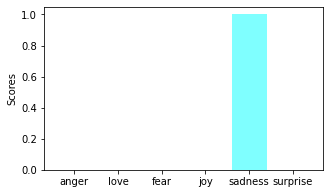

In [154]:
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,3))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['pink', 'red', 'orange', 'brown', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()